# Designs for additive model validation

In [1]:
import os
import pandas as pd
import utils.trees as ut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
results = "../nextflow/results/"
# ranking_subdir = 'default'
# ranking_subdir = 'naive_reversions_no_bp'
ranking_subdir = 'naive_reversions_first'
outbase = "output/additive-validation-design/"
metadata_csv = "../metadata.csv"

In [3]:
# output_dir = f"output/NDS-LB/test"
output_dir = f"{outbase}/{ranking_subdir}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Load metadata for 15- and 20-day GCs

In [4]:
metadata = pd.read_csv(metadata_csv, index_col=0)
metadata.query("(strain == 'wt') & (cell_type == 'GC') & (imm_duration != 'w10')", inplace=True)
metadata

,PR,imm_duration,mouse,gc,strain,node,cell_type,plate,hc_barcode,lc_barcode,row,col,old_uid,old_mouse,old_gc
uid,,,,,,,,,,,,,,,
D15_M1_GC1,2.01,d15,1,1,wt,RP,GC,2,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR2.01_mouse1_GC1A,1,1A
D15_M1_GC2,2.01,d15,1,2,wt,RI,GC,3,2,1,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR2.01_mouse1_GC1C,1,1C
D15_M1_GC3,2.01,d15,1,3,wt,LI,GC,4,14,2,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR2.01_mouse1_GC1D,1,1D
D15_M2_GC4,2.01,d15,2,4,wt,RP,GC,5,10,11,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR2.01_mouse2_GC2A,2,2A
D15_M3_GC5,2.01,d15,3,5,wt,RP,GC,6,7,4,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR2.01_mouse3_GC3A,3,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D20_M24_GC117,1.04,d20,24,117,wt,RP,GC,72,16,16,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR1.04_mouse5_GC81,5,81
D20_M25_GC118,1.02,d20,25,118,wt,RP,GC,65,8,8,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR1.02_mouse6_GC74,6,74
D20_M25_GC119,1.03,d20,25,119,wt,RP,GC,68,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR1.03_mouse6_GC77,6,77


In [5]:
metadata.imm_duration.value_counts()

imm_duration
d20    67
d15    54
Name: count, dtype: int64

In [6]:
trees = ut.load_trees(metadata, results, ranking_subdir)
len(trees)

missing tree for D15_M12_GC28
missing tree for D15_M13_GC33


119

## Top ranked bursts (by REI) at 15 and 20 days

Calculate REI for all trees

In [7]:
tau = 0.5

In [8]:
dat15 = []
dat20 = []
for idx in trees:
    ut.burst_stat(trees[idx], stat="REI", tau=tau)
    max_rei = 0
    for node in trees[idx].tree.traverse():
        if node.REI > max_rei:
            max_rei = node.REI
            max_rei_node = node.name
            max_rei_mutations = " ".join(node.mutations)
    if metadata.loc[idx].imm_duration == "d15":
        dat15.append([idx, max_rei, max_rei_node, max_rei_mutations])
    elif metadata.loc[idx].imm_duration == "d20":
        dat20.append([idx, max_rei, max_rei_node, max_rei_mutations])
    else:
        raise ValueError(f"Unknown imm_duration: {metadata.loc[idx].imm_duration}")

burst15_df = pd.DataFrame(dat15, columns=["idx", "max_REI", "max_REI_node", "mutations"]).set_index("idx").sort_values("max_REI", ascending=False).head(10)
burst20_df = pd.DataFrame(dat20, columns=["idx", "max_REI", "max_REI_node", "mutations"]).set_index("idx").sort_values("max_REI", ascending=False).head(10)
display(burst15_df, burst20_df)

,max_REI,max_REI_node,mutations
idx,,,
D15_M13_GC32,0.368842,seq1,I78(H)F Y42(L)S N108(L)K
D15_M14_GC37,0.337484,seq7,A105(H)G A40(L)G
D15_M16_GC42,0.331189,seq13,A105(H)G Y66(L)F S109(L)R
D15_M6_GC12,0.285880,seq1,Y42(L)F A52(L)S Q105(L)H
D15_M16_GC41,0.270978,seq7,A105(H)G
D15_M6_GC14,0.256066,seq2,D28(H)A L50(H)H A105(H)G G36(L)R Q95(L)H
D15_M14_GC36,0.252053,seq6,A105(H)G N108(L)K
D15_M12_GC30,0.241959,seq12,N92(H)S A40(L)G N108(L)K
D15_M10_GC21,0.216721,seq18,A105(H)G R67(L)K


,max_REI,max_REI_node,mutations
idx,,,
D20_M23_GC105,0.332031,seq12,I78(H)L N92(H)T Y42(L)C
D20_M23_GC108,0.312688,seq12,S64(H)T N92(H)K Y42(L)C N108(L)H
D20_M20_GC71,0.287833,seq2,A105(H)G A40(L)G S109(L)R
D20_M22_GC93,0.281859,seq17,Y66(L)H Q105(L)H N108(L)K L116(L)I
D20_M21_GC73,0.264482,seq11,R67(L)K Q105(L)H L116(L)I
D20_M20_GC66,0.251657,seq6,K49(H)E S57(H)N S64(H)R A105(H)G
D20_M20_GC68,0.217657,seq8,L50(H)F S57(H)N S77(H)T T96(H)S A105(H)G N108(L)K
D20_M21_GC81,0.202947,seq3,A105(H)G N108(L)K
D20_M20_GC56,0.201389,seq1,Q105(L)H L116(L)I


In [9]:
burst15_df.to_csv(f"{output_dir}/burst15.csv")
burst20_df.to_csv(f"{output_dir}/burst20.csv")

## Affinity ladder

We'll find tree sequences with multiple mutations that are predicted to lie near a grid of affinity values. These variants can be constructed and tested to validate the additive predictions.

Criteria:
- half-log steps from –4 to +4
- avoid recurrent mutation pairs
- limit mutation number to 10
- observed variants only

In [10]:
grid = np.linspace(-4, 4, 17)
grid

array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,
        1.5,  2. ,  2.5,  3. ,  3.5,  4. ])

Exclude variants with both `A105(H)G` and `N108(L)K`

In [11]:
affinity_dat = []
for idx in trees:
    for node in trees[idx].tree.traverse():
        has_epi_pair = "A105(H)G" in node.mutations and "N108(L)K" in node.mutations
        if 2 <= len(node.mutations) <= 10 and not np.isnan(node.delta_bind) and not has_epi_pair and node.abundance > 0:
            affinity_dat.append([idx, node.name, len(node.mutations), node.delta_bind, " ".join(node.mutations)])
affinity_dat = pd.DataFrame(affinity_dat, columns=["gc", "node", "n_mutations", "delta_bind", "mutations"])
# drop repeated variants from different GCs
affinity_dat.drop_duplicates("mutations", inplace=True)
affinity_dat.sort_values("delta_bind", inplace=True)
affinity_dat

,gc,node,n_mutations,delta_bind,mutations
33,D15_M1_GC1,seq21,5,-6.105945,Y38(H)D A105(H)V S56(L)A Q105(L)H Y114(L)S
4422,D20_M21_GC82,seq26,5,-6.022180,N40(H)H Q86(H)H Y87(H)C S92(L)R Y114(L)D
209,D15_M3_GC5,seq15,9,-5.982840,Y52(H)F S64(H)N N85(H)D N38(L)D V39(L)L Y42(L)...
3079,D20_M20_GC58,seq51,8,-5.975193,N40(H)H Y55(H)H Y87(H)F K51(L)Q A57(L)T N108(L...
4419,D20_M21_GC82,seq30,6,-5.974562,N40(H)H Y52(H)F Q86(H)H T123(H)A S92(L)R Y114(L)D
...,...,...,...,...,...
1363,D15_M11_GC24,seq2,7,2.819320,K49(H)R S57(H)N S64(H)R S93(H)Y A105(H)G Q105(...
1446,D15_M11_GC26,seq22,10,2.865710,D28(H)A T35(H)I S57(H)N S64(H)N L71(H)V A52(L)...
1469,D15_M11_GC26,seq39,6,2.876587,T65(H)S S7(L)P A40(L)G N108(L)H S109(L)R L116(L)I
3319,D20_M20_GC61,seq77,9,2.894842,S64(H)R T65(H)I A40(L)G Y42(L)H K51(L)R Y55(L)...


In [12]:
affinity_dat.mutations.value_counts().value_counts()

count
1    5769
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

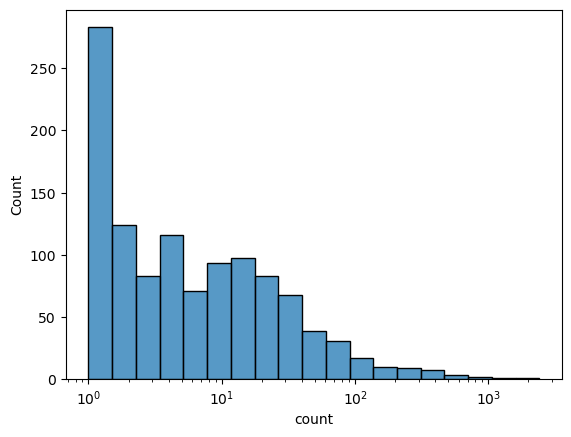

In [13]:
mutation_freq = pd.Series(" ".join(affinity_dat.mutations).split(" ")).value_counts().sort_values(ascending=False)
sns.histplot(x=mutation_freq, log_scale=True)

In [14]:
mutation_freq

A105(H)G    2413
A40(L)G     1096
Q105(L)H     778
S57(H)N      748
S64(H)R      605
            ... 
R80(H)P        1
T101(H)L       1
Y42(L)L        1
K123(L)L       1
S16(H)P        1
Name: count, Length: 1138, dtype: int64

In [15]:
near_points = pd.DataFrame()
radius = 0.2
for grid_point in grid:
    distances = (affinity_dat.delta_bind - grid_point).abs()
    new_near_points = affinity_dat.loc[distances <= radius, :].copy()
    new_near_points["grid_point"] = grid_point
    near_points = pd.concat([near_points, new_near_points])

near_points.reset_index(drop=True, inplace=True)
near_points

,gc,node,n_mutations,delta_bind,mutations,grid_point
0,D20_M24_GC115,seq68,5,-4.111039,A105(H)G N38(L)D Y55(L)S L124(L)V K127(L)T,-4.0
1,D15_M10_GC20,seq54,2,-4.092888,R106(H)G Y107(L)C,-4.0
2,D15_M10_GC20,seq37,4,-4.042329,T65(H)I R106(H)G Q48(L)H Y107(L)C,-4.0
3,D15_M13_GC34,seq65,5,-4.023282,Y38(H)D Y66(H)N A40(L)G Y66(L)S Y114(L)F,-4.0
4,D20_M25_GC121,seq36,9,-3.897145,S57(H)N Y58(H)C G63(H)D S64(H)N Y87(H)F C104(H...,-4.0
...,...,...,...,...,...,...
4611,D15_M11_GC24,seq2,7,2.819320,K49(H)R S57(H)N S64(H)R S93(H)Y A105(H)G Q105(...,3.0
4612,D15_M11_GC26,seq22,10,2.865710,D28(H)A T35(H)I S57(H)N S64(H)N L71(H)V A52(L)...,3.0
4613,D15_M11_GC26,seq39,6,2.876587,T65(H)S S7(L)P A40(L)G N108(L)H S109(L)R L116(L)I,3.0
4614,D20_M20_GC61,seq77,9,2.894842,S64(H)R T65(H)I A40(L)G Y42(L)H K51(L)R Y55(L)...,3.0


In [16]:
def group_representative_closest(df, freq_cutoff=None):
    if freq_cutoff is not None:
        # remove variants with mutations that are too frequent
        max_freqs = df.mutations.apply(lambda x: mutation_freq[x.split(" ")].max())
        df = df.loc[max_freqs <= freq_cutoff, :]
    return df.loc[df.index[np.argmin(np.abs(df.delta_bind.values[:, None] - grid).min(axis=1))], :]

ladder = near_points.groupby("grid_point").apply(group_representative_closest, include_groups=False)
ladder_nohifreq = near_points.groupby("grid_point").apply(group_representative_closest, freq_cutoff=800, include_groups=False)

display(ladder, ladder_nohifreq)

,gc,node,n_mutations,delta_bind,mutations
grid_point,,,,,
-4.0,D15_M13_GC34,seq65,5,-4.023282,Y38(H)D Y66(H)N A40(L)G Y66(L)S Y114(L)F
-3.5,D20_M21_GC78,seq9,5,-3.501339,Y58(H)H Y55(L)H E101(L)D Y114(L)N L116(L)I
-3.0,D20_M22_GC87,seq8,7,-3.004123,M53(H)L Y87(H)C A105(H)V T37(L)S N38(L)Y A40(L...
-2.5,D20_M20_GC68,seq10,5,-2.508924,S57(H)N S64(H)N A105(H)V Y68(L)H K123(L)N
-2.0,D20_M21_GC79,seq50,7,-2.000404,Y55(H)N Y58(H)N T79(H)S A105(H)G A52(L)S G78(L...
-1.5,D15_M3_GC5,seq33,3,-1.505276,A105(H)G Y107(L)H S109(L)I
-1.0,D20_M22_GC90,seq33,5,-1.000819,S57(H)N Y102(H)H T122(H)S T37(L)I L116(L)P
-0.5,D20_M23_GC111,seq28,5,-0.503469,S64(H)N T96(H)S Y42(L)N A52(L)V F87(L)L
0.0,D20_M22_GC88,seq28,6,0.001125,I76(H)F A52(L)T Y68(L)F D74(L)G L99(L)W L116(L)P


,gc,node,n_mutations,delta_bind,mutations
grid_point,,,,,
-4.0,D15_M10_GC20,seq37,4,-4.042329,T65(H)I R106(H)G Q48(L)H Y107(L)C
-3.5,D20_M21_GC78,seq9,5,-3.501339,Y58(H)H Y55(L)H E101(L)D Y114(L)N L116(L)I
-3.0,D20_M25_GC121,seq23,4,-2.988956,Y38(H)N S57(H)R Y66(H)N E97(H)D
-2.5,D20_M20_GC68,seq10,5,-2.508924,S57(H)N S64(H)N A105(H)V Y68(L)H K123(L)N
-2.0,D15_M1_GC2,seq15,3,-1.992917,T77(L)I E97(L)D Y107(L)H
-1.5,D15_M6_GC13,seq68,4,-1.507264,T101(H)S G78(L)Y E101(L)D E125(L)A
-1.0,D20_M22_GC90,seq33,5,-1.000819,S57(H)N Y102(H)H T122(H)S T37(L)I L116(L)P
-0.5,D20_M23_GC111,seq28,5,-0.503469,S64(H)N T96(H)S Y42(L)N A52(L)V F87(L)L
0.0,D20_M22_GC88,seq28,6,0.001125,I76(H)F A52(L)T Y68(L)F D74(L)G L99(L)W L116(L)P


In [17]:
ladder.to_csv(f"{output_dir}/ladder.csv")
ladder_nohifreq.to_csv(f"{output_dir}/ladder_nohifreq.csv")